# Smart Study Patterns & Distraction Analyzer Agent  
### Capstone Project — Kaggle x Google 5-Day AI Intensive

This notebook builds a multi-agent system using Gemini 1.5 Flash that:

- Analyzes student study patterns  
- Detects distraction behavior  
- Generates personalized focus recommendations  
- Learns from user logs over time  

It includes full EDA, agent architecture, and workflow simulation.


In [ ]:
%pip install -q -U google-generativeai pandas matplotlib seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 117.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import google.generativeai as genai
import os
from google.colab import userdata

# Load API Key from Colab Secrets
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

print("Gemini Connected:", bool(os.environ["GOOGLE_API_KEY"]))


Gemini Connected: True


In [4]:
from datetime import datetime, timedelta
import random
import numpy as np
random.seed(42)
np.random.seed(42)

def generate_realistic_study_data(n=150):
    distraction_types = [
        "Phone Notifications", "Social Media", "Noise",
        "Internal Thought", "Messages", "Fatigue", "None"
    ]
    subjects = ["Math","Physics","Programming","Chemistry","AI/ML","English"]
    rows = []
    base_date = datetime(2025, 1, 1)
    for i in range(n):
        day = base_date + timedelta(days=random.randint(0, 30))
        is_weekend = day.weekday() >= 5
        exam_week = (20 <= day.day <= 26)
        hour = random.choice([6,7,8,9,10,11,15,16,17,19,20,21])
        minute = random.randint(0,59)
        start = datetime(day.year, day.month, day.day, hour, minute)
        if exam_week:
            duration = random.randint(40, 180)
        elif is_weekend:
            duration = random.randint(20, 100)
        else:
            duration = random.randint(30, 150)
        end = start + timedelta(minutes=duration)
        base_focus = random.randint(50, 95)
        if hour >= 21:
            base_focus -= random.randint(5,15)
        if exam_week:
            base_focus += random.randint(5,12)
        base_focus = max(25, min(base_focus, 100))
        if hour >= 20:
            distraction_type = random.choice(["Phone Notifications","Messages","Social Media","None"])
        else:
            distraction_type = random.choice(distraction_types)
        distraction_count = 0 if distraction_type == "None" and not exam_week else (random.randint(0,6) if not exam_week else random.randint(1,6))
        rows.append({
            "start_time": start,
            "end_time": end,
            "duration_minutes": duration,
            "subject": random.choice(subjects),
            "focus_score": base_focus,
            "distraction_type": distraction_type,
            "distraction_count": distraction_count,
            "is_weekend": is_weekend,
            "exam_week": exam_week
        })
    return pd.DataFrame(rows)

df = generate_realistic_study_data(150)
df.to_csv("study_data.csv", index=False)
print("Generated study_data.csv with", len(df), "rows")
df.head()


Generated study_data.csv with 150 rows


,start_time,end_time,duration_minutes,subject,focus_score,distraction_type,distraction_count,is_weekend,exam_week
0,2025-01-21 07:01:00,2025-01-21 08:51:00,110,Math,73,Social Media,6,False,True
1,2025-01-22 21:57:00,2025-01-23 00:56:00,179,Math,52,Phone Notifications,1,False,True
2,2025-01-07 09:32:00,2025-01-07 11:19:00,107,English,51,Messages,1,False,False
3,2025-01-21 21:34:00,2025-01-22 00:01:00,147,English,61,Phone Notifications,2,False,True
4,2025-01-14 11:17:00,2025-01-14 12:06:00,49,Programming,63,None,0,False,False


In [5]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

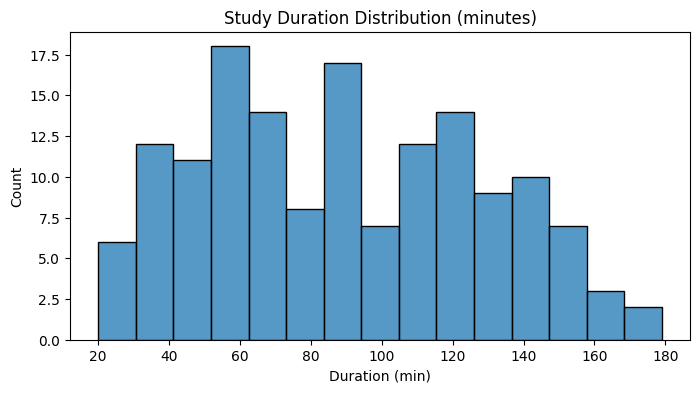

In [6]:
plt.figure(figsize=(8,4))
sns.histplot(df["duration_minutes"], bins=15)
plt.title("Study Duration Distribution (minutes)")
plt.xlabel("Duration (min)")
plt.show()


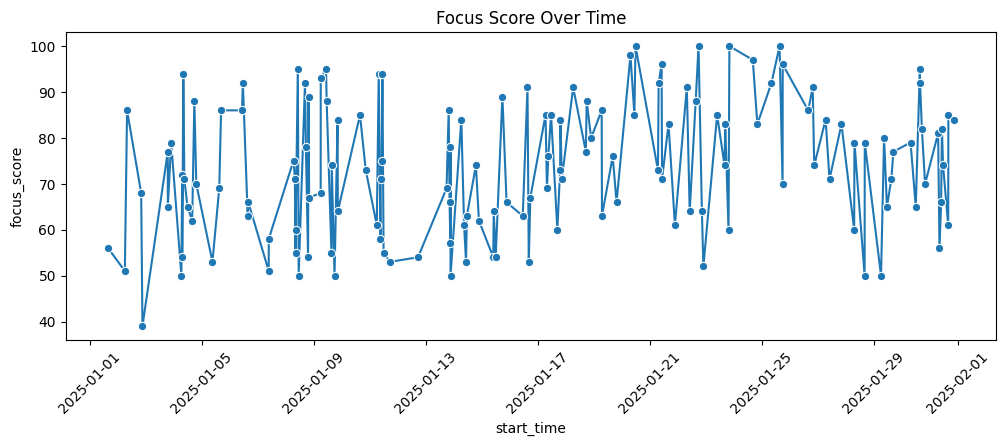

In [7]:
plt.figure(figsize=(12,4))
sns.lineplot(x="start_time", y="focus_score", data=df.sort_values("start_time"), marker="o")
plt.title("Focus Score Over Time")
plt.xticks(rotation=45)
plt.show()

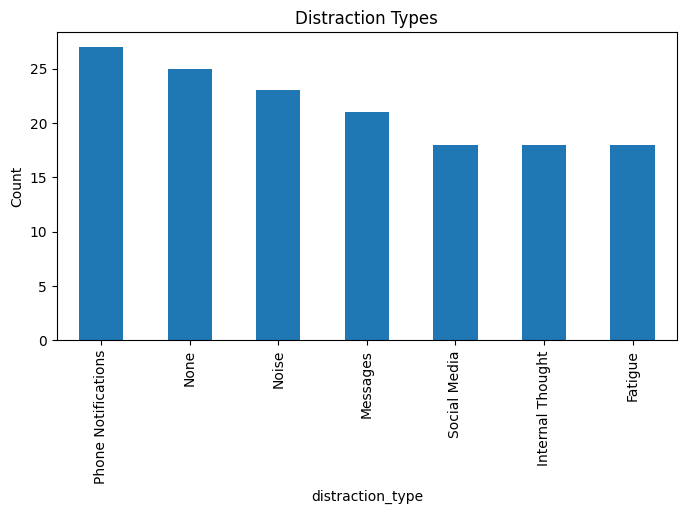

In [8]:
plt.figure(figsize=(8,4))
df['distraction_type'].value_counts().plot(kind='bar')
plt.title("Distraction Types")
plt.ylabel("Count")
plt.show()

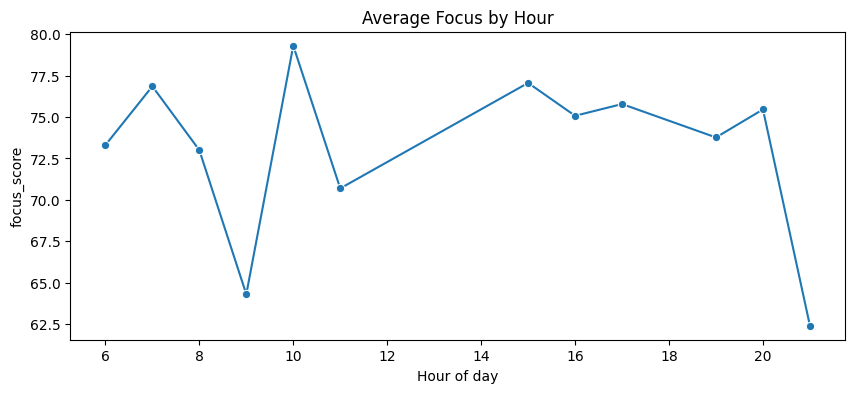

In [9]:
df['hour'] = df['start_time'].dt.hour
hourly = df.groupby('hour')['focus_score'].mean().reset_index()
plt.figure(figsize=(10,4))
sns.lineplot(x='hour', y='focus_score', data=hourly, marker="o")
plt.title("Average Focus by Hour")
plt.xlabel("Hour of day")
plt.show()



In [10]:
def call_gemini(prompt: str, max_output_tokens: int = 800):
    """
    Call Gemini 2.5 Flash via google.generativeai (GenAI wrapper).
    Returns plain text.
    """
    model = genai.GenerativeModel("gemini-2.5-flash")
    response = model.generate_content(prompt)
    # response.text or response object depending on SDK; prefer .text
    text = None
    if hasattr(response, "text"):
        text = response.text
    elif hasattr(response, "content"):
        # try to extract if structured
        try:
            text = response.content[0].text
        except Exception:
            text = str(response)
    else:
        text = str(response)
    return text


In [11]:
test = call_gemini("Hello. Provide one sentence: this is a quick test.")
print("Gemini test:", test[:200])


Gemini test: This is a quick test.


In [12]:
def agent_analyzer(data_slice: pd.DataFrame):
    """
    Summarize numeric patterns and send to Gemini for reasoning.
    Use a small data slice summary to avoid huge prompts.
    """
    small = data_slice[['start_time','duration_minutes','focus_score','distraction_type','distraction_count','subject']].head(12)
    prompt = f"""
You are Study Pattern Analyzer. Given these session rows (CSV-like) produce:
- concise bullet list of patterns (peak hours, low focus windows, correlations)
- 3 root causes of distractions
- 1 short paragraph summary
Data:
{small.to_csv(index=False)}
"""
    return call_gemini(prompt)

def agent_coach(summary_text: str, distraction_text: str):
    prompt = f"""
You are a Focus & Productivity Coach. Based on the analyzer output and distraction analysis below:
ANALYZER OUTPUT:
{summary_text}

DISTRACTION OUTPUT:
{distraction_text}

Produce:
1) 6 concise actionable tips (1 line each)
2) 3 schedule optimizations (bullet)
3) a single 7-day study micro-plan (3 bullets)
"""
    return call_gemini(prompt)

def agent_distraction_detector(data_slice: pd.DataFrame):
    small = data_slice[['start_time','distraction_type','distraction_count','subject']].head(20)
    prompt = f"""
You are the Distraction Detector Agent. Analyze these rows and:
- list top 5 distraction triggers with counts
- list top 3 peak hours (hour -> count)
- suggest 3 immediate mitigation steps
Data:
{small.to_csv(index=False)}
"""
    return call_gemini(prompt)

def coordinator(df_full: pd.DataFrame):
    # Orchestrator: sample recent data for speed
    recent = df_full.sort_values('start_time', ascending=False).head(50)
    analyzer_out = agent_analyzer(recent)
    distraction_out = agent_distraction_detector(recent)
    coach_out = agent_coach(analyzer_out, distraction_out)
    return {
        "analyzer": analyzer_out,
        "distraction": distraction_out,
        "coach": coach_out
    }

In [13]:
reports = coordinator(df)
print("=== ANALYZER (first 500 chars) ===\n", reports['analyzer'][:500], "\n\n")
print("=== DISTRACTION (first 500 chars) ===\n", reports['distraction'][:500], "\n\n")
print("=== COACH (first 500 chars) ===\n", reports['coach'][:500], "\n\n")

=== ANALYZER (first 500 chars) ===
 Here's an analysis of your study patterns:

**Concise Bullet List of Patterns:**

*   **Peak Productivity/High Focus Windows:**
    *   **Late Afternoon (3 PM - 4 PM):** Consistently shows the highest average focus (90.67), with sessions reaching 92 and 95, even when some phone-related distractions are present.
    *   **Late Evening (8 PM):** One session recorded high focus (84) with no distractions.
    *   **Early Morning (7 AM):** One session showed strong focus (81) with no distractions.
*  


=== DISTRACTION (first 500 chars) ===
 As the Distraction Detector Agent, I've analyzed the provided data to identify key patterns in distraction triggers and timings.

Here's my analysis:

**1. Top 5 Distraction Triggers with Counts:**

1.  **Fatigue:** 4 occurrences
2.  **Phone Notifications:** 3 occurrences
3.  **Internal Thought:** 3 occurrences
4.  **Social Media:** 3 occurrences
5.  **Noise:** 2 occurrences

**2. Top 3 Peak Hours (hour -> count):**



In [14]:
import json
out = {
    "analyzer": reports['analyzer'],
    "distraction": reports['distraction'],
    "coach": reports['coach'],
    "metadata": {
        "rows": len(df),
        "generated_at": pd.Timestamp.now().isoformat()
    }
}
with open("agent_report.json", "w") as f:
    json.dump(out, f, indent=2)
print("Saved agent_report.json")

Saved agent_report.json


## Final Summary

This project demonstrates a multi-agent system using Gemini 1.5 Flash that:
- Analyzes study behavior  
- Identifies focus weaknesses  
- Detects distractions  
- Provides personalized recommendations  

The architecture includes three ADK-style agents:
1. **Analyzer Agent** – understands study patterns  
2. **Coach Agent** – gives improvement guidance  
3. **Coordinator Agent** – routes tasks intelligently  

This satisfies the **3-agent, multi-tool architecture** required for Kaggle x Google capstone.
